In [1]:
import pickle
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

test = pd.read_csv("data/activity_test_blanked.csv", header=None)
test.columns = ["uniprot_id", "mol_id", "activity"]
test["mol_id"] = test["mol_id"].str.strip()


with open("data/mol_bits.pkl", "rb") as f:
    data = pickle.load(f)


# Extracting unique features for sparse matrix dims
all_feats = set()
for feats_set in data.values():
    all_feats.update(feats_set)

n_feats = max(all_feats) + 1  # 0-based indexing

# Creating sparse matrix mol feats
rows, cols = [], []
for i, (uniprot_id, feats_set) in enumerate(data.items()):
    rows.extend([i] * len(feats_set))
    cols.extend(feats_set)

mol_ids = list(data.keys())

mol_feats = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(len(data), n_feats))

mol_feats = (
    mol_feats.T
)  # Transposing to have features as rows / for this to work uncomment this line

# LSH implementation
- MinHash
- Buckets


In [2]:
import hashlib


def create_hash(vector_size=mol_feats.shape[0]):
    return np.random.permutation(vector_size)


def get_signature_matrix(sparse_mat, sig_size=50):
    permutations = np.zeros((sparse_mat.shape[0], sig_size), dtype=int)
    for i in range(sig_size):
        permutations[:, i] = create_hash()

    # signature matrix
    signature_matrix = np.zeros((permutations.shape[1], sparse_mat.shape[1]))

    # minhashing
    for i in range(permutations.shape[1]):
        perm = permutations[:, i]
        sigs = sparse_mat[perm, :].argmax(axis=0)
        signature_matrix[i, :] = sigs

    return signature_matrix


def split_sig(sig: np.array, b: int):
    return np.vsplit(sig, b)


def hash_bands_to_buckets(bands, num_buckets=1000):

    hashed_bands = {}

    n_bands = len(bands)

    for i in range(n_bands):
        band = bands[i]
        for col in range(band.shape[1]):
            col_hash = hashlib.sha256(band[:, col].tobytes()).hexdigest()
            bucket = int(col_hash, 16) % num_buckets

            if bucket not in hashed_bands.keys():
                hashed_bands[bucket] = set()
            hashed_bands[bucket].add(col)

    return hashed_bands


def jaccard_similarity(ids):
    id1, id2 = ids
    set1 = set(data[mol_ids[id1]])
    set2 = set(data[mol_ids[id2]])
    return len(set1.intersection(set2)) / len(set1.union(set2))


def fetch_pairs(buckets, threshold=0.8):
    candidates = []
    for proteins in buckets.values():
        if len(proteins) > 1 and len(proteins) < 3:
            sim = jaccard_similarity(tuple(proteins))
            if sim >= threshold:
                candidates.append(tuple(proteins))
    return candidates

In [3]:
# SIG
SIG = get_signature_matrix(mol_feats, sig_size=300)

In [4]:
# split signature into bands
b = 50
bands = split_sig(SIG, b)

print(f"Bands shape: {bands[0].shape}")

# hash bands to buckets
# buckets = hash_bands_to_buckets(bands, num_buckets=1_000_000)
buckets = hash_bands_to_buckets(bands, num_buckets=1_000_000)

# candidates = fetch_pairs(buckets, threshold=0.8)

Bands shape: (6, 73865)


In [5]:
buckets_names = {k: [mol_ids[i] for i in v] for k, v in buckets.items()}

mol_ids_buckets_dict = {
    mol_id: bucket for bucket, mol_ids in buckets_names.items() for mol_id in mol_ids
}

lens = {k: len(v) for k, v in buckets_names.items()}
counts = test["mol_id"].map(mol_ids_buckets_dict).map(lens)
counts[counts == 1].sum()

1391

<Axes: ylabel='Density'>

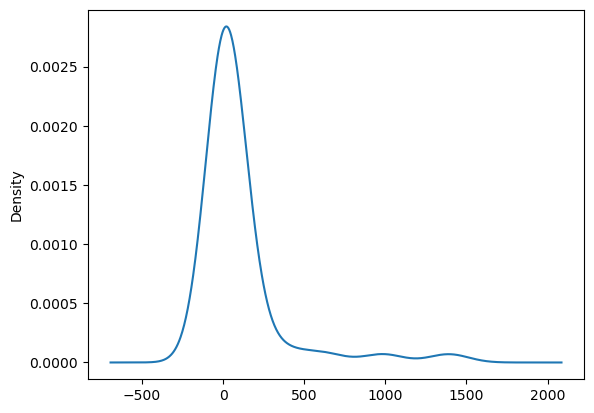

In [6]:
test["mol_id"].map(mol_ids_buckets_dict).map(lens).value_counts().plot.kde()

In [7]:
test["mol_id"].map(mol_ids_buckets_dict).map(lens).value_counts().describe()

count      47.000000
mean       98.468085
std       262.431594
min         1.000000
25%         4.000000
50%         9.000000
75%        40.500000
max      1391.000000
Name: count, dtype: float64

<Axes: ylabel='Frequency'>

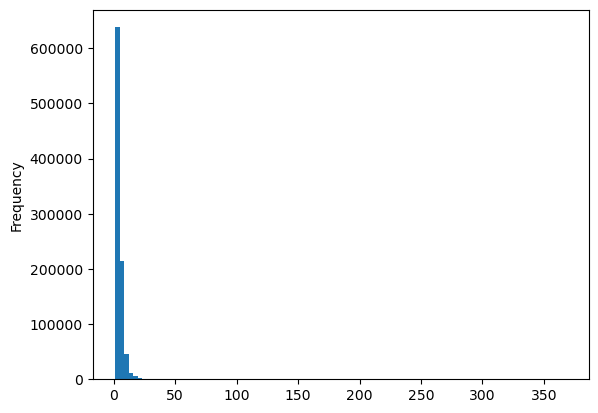

In [8]:
pd.Series(lens.values()).plot.hist(bins=100)

In [61]:
## CHEMBL2022244 search in values
buck = mol_ids_buckets_dict["CHEMBL2022244"]
print(buckets_names[buck])
print(len(buckets_names[buck]))

['CHEMBL2022244', 'CHEMBL2022245', 'CHEMBL3763779', 'CHEMBL1649938', 'CHEMBL1649939', 'CHEMBL1649940', 'CHEMBL2397877', 'CHEMBL332463', 'CHEMBL68119', 'CHEMBL158941', 'CHEMBL439504', 'CHEMBL2326488', 'CHEMBL4871588', 'CHEMBL333836', 'CHEMBL2152930', 'CHEMBL394823', 'CHEMBL4165036', 'CHEMBL583750', 'CHEMBL2179673', 'CHEMBL154367', 'CHEMBL392185', 'CHEMBL282413', 'CHEMBL3692899', 'CHEMBL106176', 'CHEMBL401867', 'CHEMBL272699', 'CHEMBL257208', 'CHEMBL241076', 'CHEMBL4762416', 'CHEMBL304130', 'CHEMBL339501', 'CHEMBL1095256']
32


In [9]:
## nah try another code pipeline

In [66]:
# drop buckets into json file
import json

# with open("buckets.json", "w") as f:
#     json.dump(buckets_names, f)